In [1]:
print("hello")

hello


### We intend to build a recommendation system to increase the quality of products and ads that we show to customers , to do so we based our data on a dataset of the UK's retailers , we want to transform that data into a customer centric dataset to segmentate customers into different clusters

In [2]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [3]:
# this is so we can use plotly localy in our notebook
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [4]:
# Overwrite some style properties for Seaborn plots
sns.set_theme(rc={'axes.facecolor': '#7df9ff'}, style='darkgrid')

In [5]:
# Let's load the data
df = pd.read_csv("data.csv" , encoding="ISO-8859-1")
df_origin = df
# see what the data looks like
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
# see what the .csv file contains (columns)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### As we can see here there are 7 colums
There is a total of 541909 entries and as you might have noticed , we have some missing data in some columns like CustomerID and Description

In [7]:
# To further understand the data we will need to get more infor about it
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


#### As you can see we have a second problem : illogical values
- This can be observed by the fact the the min in both quatity and UnitPrice are negative  :'(
- This is the case of outliyers as shown by the 75% and 25% precentiles

In [8]:
# this includes the other feilds and the top most repeated words in each of them
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


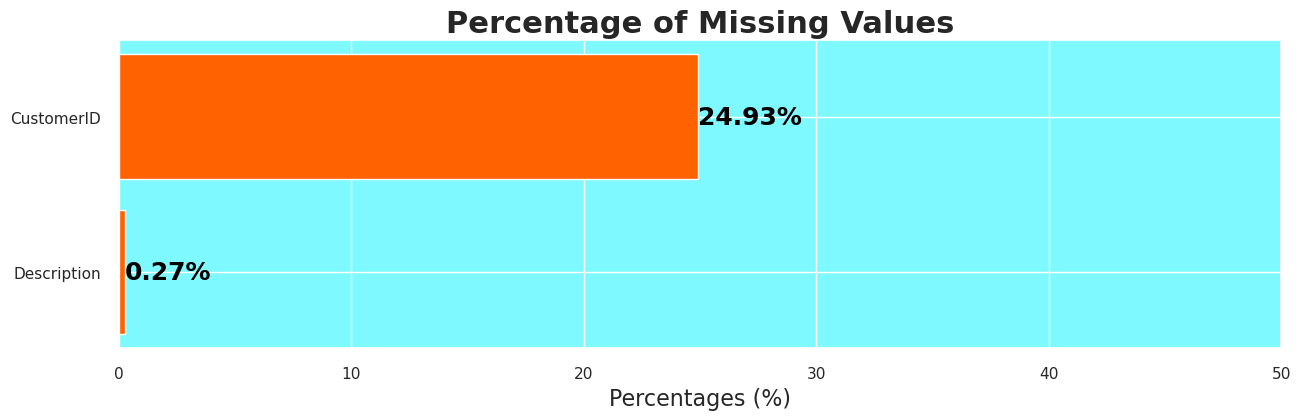

In [9]:
# calculating the mising data
missing_data = df.isnull().sum() # sums each colum seperatly
# give the percentage for each column
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100 # shapes the dataset to line-col (only lines in this case)
#                                                                      ^ forgot to multiply bruh

print(missing_data)
# Srting the vales so they are better presented
missing_percentage.sort_values(ascending=True, inplace=True)

# Ploting
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Annotate the values and indexes
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Set x-axis limit
ax.set_xlim([0, 50])

plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()





#### the imediate issue is that there is a quarter of customers data missing which is huuuge , and to avoid any bias here the most optimal solution is remove them and see how the data will behave

#### while de Description data colums despite there being 1400~ values missing , it's nothing compared to the whole set as shown by the percentage

#### there are also inconsistencies we have to keep in mind as shown by the min and max values above

- seeing the low precentage in the Description column it's better theoretically to remove these and potentially have a cleaner dataset

In [10]:
# let's remove the missing data from the dataset
df = df.dropna(subset=['CustomerID', 'Description'])

In [11]:
print(df.isnull().sum())
# no missing data now
# we can focus on inconsistencies and duplicates rn

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [12]:
# Finding duplicate rows (keeping all instances)
duplicate_rows = df[df.duplicated(keep=False)]

# Sorting the data by certain columns to see the duplicate rows next to each other
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

duplicate_rows_sorted.head(10)



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [13]:
print(f"number of duplacted values is : {df.duplicated().sum()}")

# removing the duplicates
df.drop_duplicates(inplace=True)


number of duplacted values is : 5225


/tmp/ipykernel_861619/3652470560.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
# (visualising the precentage of the data left after cleaning so far)
print(f"percentage of data left after cleaning is {(df.shape[0]/df_origin.shape[0])*100:.2f} %")

percentage of data left after cleaning is 74.11 %


In [15]:
# On thing that you might not have noticed is that Invoice despite it being (visually) a number it's not counted as one even after cleaning
# which might indicate that there are string values somewhere m let's find out

df.sort_values(['InvoiceNo'])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541717,C581569,20979,36 PENCILS TUBE RED RETROSPOT,-5,12/9/2011 11:58,1.25,17315.0,United Kingdom


In [16]:
# as you can see here , there are values that start with C and negative Quatity which indicates that these are returned elements
# ofc we can't just leave it like like this

# Filtering out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Let's take the cancelled returned elements/transactions
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']

# we gonna peek at it now like a sussy little sh-
print(cancelled_transactions.describe().drop('CustomerID', axis=1))



           Quantity     UnitPrice
count   8872.000000   8872.000000
mean     -30.774910     18.899512
std     1172.249902    445.190864
min   -80995.000000      0.010000
25%       -6.000000      1.450000
50%       -2.000000      2.950000
75%       -1.000000      4.950000
max       -1.000000  38970.000000


/tmp/ipykernel_861619/3167457673.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### As we can see the quatities are negative which does not indicate a problem in the data actually , but rather the returned elements and their quantities

### Looking at the Unit price we can see that the elements returned price values have a decent amount of variety

### Important note : we do actually need to keep these data here since we want to know what products to recommend to customers and cancelled objects play an important role in that

#### for one it enhances the clustering process by incorporating patterns and trends observed in cancellation data

#### secondly , it ,might prevent certain bad products from being recommended to to them being returned a lot of times

In [17]:
# to get an idea on what is the percentage of the returned item we do :

print(f"Precentage of returned products : {(cancelled_transactions.shape[0] / df.shape[0]) * 100:.2f}%")

Precentage of returned products : 2.21%


In [18]:
# To get an idea of what are the top 10 products that sold where , we need first to get the unique codes for each product

unique_stock_codes = df['StockCode'].nunique()

print(f"The number of unique stock codes is: {unique_stock_codes} \n")

# to get the top 10 repeated one we use
top_10_prods_code_num = df['StockCode'].value_counts().head(10) * 100 # kinda like a group by with addition to each iteration

top_10_prods_code_num

The number of unique stock codes is: 3684 



StockCode
85123A    206500
22423     189400
85099B    165900
47566     140900
84879     140500
20725     134600
22720     122400
POST      119600
22197     111000
23203     110800
Name: count, dtype: int64

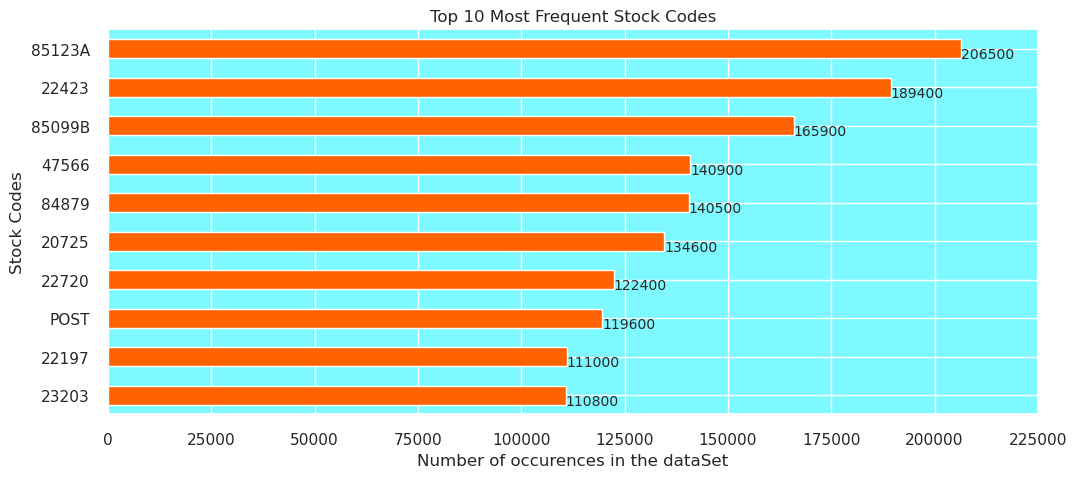

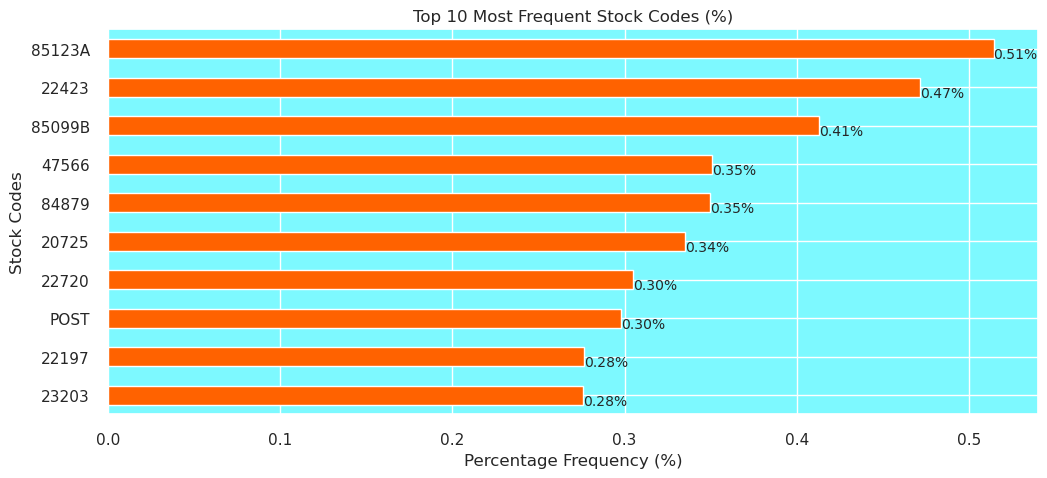

In [19]:

# same thing as above just wth percentages this time
top_10_prods_code_percentage = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_10_prods_code_num.plot(kind='barh', color='#ff6200')

# Loop on each barre to give it a description and a name (code name)
for index, value in enumerate(top_10_prods_code_num): # enumerate here is like taking the int value from the data given and looping around each one ,
    #at least from what i understood
    plt.text(value, index+0.25, value, fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Number of occurences in the dataSet')
plt.ylabel('Stock Codes')
plt.xlim([0,225000])
plt.gca().invert_yaxis()
plt.show()


# Plotting the top 10 most frequent stock codes in percentage
plt.figure(figsize=(12, 5))
top_10_prods_code_percentage.plot(kind='barh', color='#ff6200')

# Loop on each barre to give it a description and a name (code)
for index, value in enumerate(top_10_prods_code_percentage):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes (%)')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

### As we have seen above , there are 3684 unique stock codes in the dataset which implifies a large variety of products available for purchase

### This top 10 is gonna give an insight about the frequently ordered / popular products or categories

### Another thing you might have noticed and it's the code "POST" , this maybe related to postage fees perhaps or order deliveries ??

### we should further investigate theses "POST" code and see what they are later on

In [20]:
# As you may have noticed most of the codes have 5 numerical values , except for "POST"
# to investigate we are gonna see the number of codes that have a 5 numerical values

unique_stock_codes = df['StockCode'].unique()
# this basically returns 2 values , one is the length of numerical vals (using lambda method and isdegit method)
# with valuecount , counting the number of occurences
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

print("Val | num of occurences for char len")
print("----------------------------------")
print(numeric_char_counts_in_unique_codes)


Val | num of occurences for char len
----------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


#### we can conclude that we have 7 codes that don't have any numerical characters in them (like POST above) and only one stock code with one numerical value

To investigate further we need to take a look at these special cases

In [21]:
# This will help us see what are the stock codes with 0 and 1 numeric characters
anomaly_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Printing each stock code on a new line
print("Anomalous stock codes:")
print("----------------------")
for code in anomaly_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


#### Now supposedly we want to remove this data completely how much is its percentage compared to all the data

In [22]:
anomaly_percentage = ((df['StockCode'].isin(anomaly_stock_codes).sum())/df.shape[0])*100

# the use of sum is quite smart here since the dataSet given here "df['StockCode'].isin(anomaly_stock_codes).sum()"
# Since we will just have True and false and since we are counting False as 0 , it basically only counts all the True rows
print(f"percentage of anomaly records is : {anomaly_percentage:.2f}%")

percentage of anomaly records is : 0.48%


### Based on the percentage we can see that this represents a very small portion of our entire data so far these also have a high probability to not be products even as their name suggests "BANK CHARGES" and "POST"+ they represent 8 out of 3684 unique stock code

### Thus for better accuracy for our prediction this anomalous stock codes data will be removed to focus more on actual products and proceed to the next step

In [23]:
# Removing rows with anomalous stock codes from the dataset
# ? note: ~ helps flip the booleans in this case , to keep just the ones that are NOT in anomaly_stock_codes
df = df[~df['StockCode'].isin(anomaly_stock_codes)]

# check row count
df.shape[0]

399689

### After cleaning the stock codes , it's time to check description to see if there is a similar behaviour as what we have seen above with stock codes

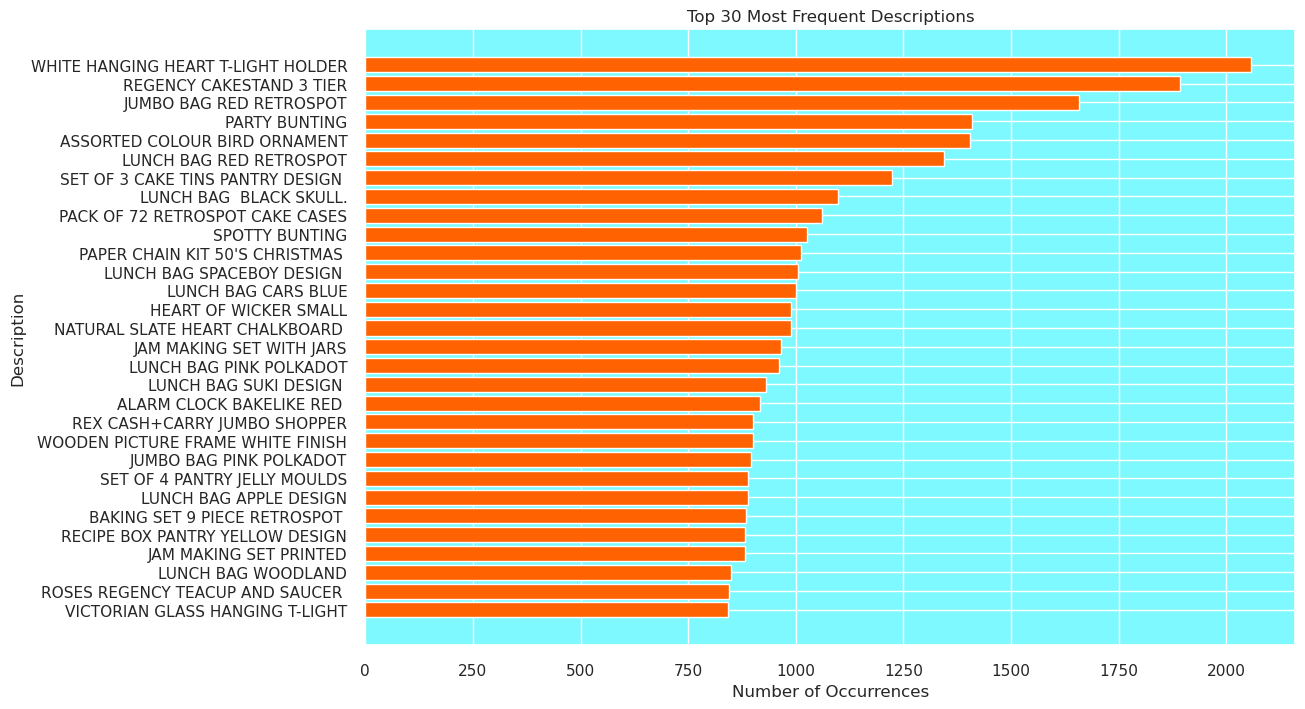

In [24]:
# Calculate the occurrence of each unique description and sort them
description_num = df['Description'].value_counts() # this is already sorted

# Get the top 30 descriptions
top_30_descriptions = description_num[:30]


# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

### We might have notices a pattern here
- 1) Most of these items are household items associated with kitchenware, lunch bags, and decorative items
- 2) You may have noticed that all the names are in uppercase , which might indicate a tandardized format for entering product descriptions in the database , HOWEVER as we might have seen above there might be some inconsistencies , so we'll have to check for lowercase words as it is the most probable difference due to the uppercase behviour.

In [25]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("------------------------------------------------------------")
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


#### Looking at these they all seem normal except for thse 2 :
- Next Day Carriage
- High Resolution Image

In [26]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

matches1 = pd.Series(df['Description']).apply(lambda x: (str(x)==service_related_descriptions[0] or str(x)==service_related_descriptions[1])).value_counts(normalize=True)

print(f"The service related description represent {matches1.iloc[1]*100:.2f}% of the dataset")

The service related description represent 0.02% of the dataset


In [27]:
# since the percentage is so low and again for the sake of consistency it is safer to remove this data
df = df[~df['Description'].isin(service_related_descriptions)]

# again for consitency , we will uppercase all the Description feilds
df['Description'] = df['Description'].str.upper()


# Getting the number of rows left in the dataframe
df.shape[0]

399606

### After checking the description we will have to address the 0 values in the unite price field

In [28]:
# checking the UnitePrice column again
df['UnitPrice'].describe()

count    399606.000000
mean          2.904957
std           4.448796
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

### The minimum unit price value is zero. This suggests that there are some transactions where the unit price is zero, potentially indicating a free item or a data entry error.

### either way we will have to check it out , to understand the nature and behaviour of this data

In [29]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


### Things noticed
- the number of these 0 transactions is fairly low at only 33 transactions
- the range is HUGE as indicated by the standard diviation , the min and the max , which might indicate potetial error data , and no one wants that.

### What to do
-> yoink it out of the dataset to avoid problems

In [30]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[df['UnitPrice'] > 0]

### We will try using K-means algoritm later for clustering our data ,to do that we will have to address outliers as k-means is very sensitive to both the scale of data and the presence of outliers

### BUT! , at this stage, the data is transactional, and removing outliers might eliminate valuable information that could play a crucial role in segmenting customers later on. Therefore, we will postpone the outlier treatment and proceed to the next stage for now.

In [31]:
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)

# how much of the data is left
df.shape[0]

399573

### In order to create a comprehensive customer-centric dataset for clustering and recommendation, the following features can be engineered from the available data:
i read about RFM [here](https://www.datacamp.com/tutorial/introduction-customer-segmentation-python)
- RFM is a method for analyzing customer value and segmenting the customer base , it has 3 main parts:
  - Recency (R): This metric indicates how recently a customer has made a purchase. A lower recency value means the customer has purchased more recently, indicating higher engagement with the brand.
  - Frequency (F): This metric signifies how often a customer makes a purchase within a certain period. A higher frequency value indicates a customer who interacts with the business more often, suggesting higher loyalty or satisfaction.
  - Monetary (M): This metric represents the total amount of money a customer has spent over a certain period.the bigger the number the more the customer's contribution in the business.

### All these metrics will help use define the customers behaviour and but we will need to approach each one separatly

#### 1- Recency
- this can be achieved in thos dataset by looking at the invoiceDates , i.e how many days since the customer last purchased something
- a lower value means he came just recently
- a higher value may mean that the customer is or may not be interseted by the products

#### With this businesses can tailor their marketing strategies to re-engage customers who have not made purchases in a while, potentially increasing customer retention and fostering loyalty.

In [32]:
# Convert InvoiceDate to datetime type
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase datefor each customer (basically using max for each customer and then resetting the indexing)
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()
print(most_recent_date)

# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
# This is compared to the most recent date as the data dates back to 2010-2012 so we can't subtract the current system time for the sake of consistency
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
# just for visualization here
customer_data.drop(columns=['InvoiceDay'], inplace=True)

2011-12-09


In [33]:
# see what it looks like
# sort by days since last purschase
customer_data.head(10).sort_values(by='Days_Since_Last_Purchase')

,CustomerID,Days_Since_Last_Purchase
1,12347.0,2
3,12349.0,18
9,12356.0,22
5,12352.0,36
2,12348.0,75
6,12353.0,204
8,12355.0,214
7,12354.0,232
4,12350.0,310
0,12346.0,325


### side note here:
- the customer_data dataFrame we built will contain all the RFM features, so we are going to build on it

#### 2- Frequency

- we will base off of 2 things here :
  - Total transactions : simply how many times they bought something , this will help understand the customer's engagement
  - Total Products purchased : the first one will not fit well in context withou knowing the the number of products they purschased and vis-versa
  
These features will be crucial in segmenting customers based on their buying frequency, which will determine the customer segments and what to recommend for him

In [34]:
# Calculate the total number of transactions made by each customer
# kinda like a similar approache to what we did above
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index() # sum all transactions for each unique customer
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True) # simple column rename


# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index() # similar thing to what we did above
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merging the new features into the customer_data dataframe
# This was a method i have never used before so , it's good to know :D
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID') # merge  the colums of Total_Transactions and bind each row to its corresponding CustomerID
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID') # same thing here but for total_products_purchased

# display the customer RFM so far
customer_data.head(10)


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196
5,12352.0,36,8,463
6,12353.0,204,1,20
7,12354.0,232,1,530
8,12355.0,214,1,240
9,12356.0,22,3,1573


#### 3- Frequency

- we will base off of 2 things here :
  - Total spent : this is different than the total transactions since here we are calculating the total amout of money they spent (for each customer) , it's calculated by summing the product of Quantity and UnitPrice for each customer
  - Average Transaction Value: This feature is calculated as the Total Spend divided by the Total Transactions for each customer. It indicates the average value of a transaction carried out by a customer. You might ask why ? , well this is simply to understand the sending behaviour of the customer if they for example only like to purchase small/cheap products this number is going to be low and ig you can see the pattern i am going for here
  
These features will be crucial in segmenting customers based on their buying frequency, which will determine the customer segments and what to recommend for him

In [35]:
# Calculate the total spend by each customer
df['Total_Spend'] = df['UnitPrice'] * df['Quantity'] # the product of UnitPrice and quantity
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index() # group by customerID and sum

# Calculate the average transaction value for each customer
# we already have the total transactions for each costumer from total_transactions , so we merge it like we did to previous dataframes
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
# perform the calculation for each row
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


### Product diversity
#### we will now start anlysing the diversity in the customer products behaviour
- why? -> to understand and personalise product recommendations to customer thus attracting them more
- how? -> we are gonna try seeing all the different unique products that each customer bought , a higher number will indicate that the customer buys a lot of different things while a lower value might indocate the customer's focus on a certain categorie/product

Understanding the diversity in product purchases can help in segmenting customers based on their buying diversity, which can be a critical input in personalizing product recommendations.

In [36]:
# Calculate the number of unique products purchased by each customer
# unique_products_purchased = df.groupby('CustomerID')['StockCode'].unique().reset_index() <- this was just a test
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


### How do customers behave ?
#### here we will aim to understand and capture the shopping patterns and behaviors of customers. These features will give us insights into the customers' preferences regarding when they like to shop

- To do this we will introduce 3 features:
  - Average days between Purchases: this is self explanatory by its name , but the purpose of it is quite simple when you see it and it's predicting when the customer is gonna comeback to purchase something again , this might help in recommending and promoting products to the customer at the right time
  - Favourite Shopping day: this one is self explanatory as well , its purpose is to help in identifying the preferred shopping days of different customer **segments**, which can be used to optimize marketing strategies and promotions for different days of the week
  - Favourite shopping hour: This refers to the hour of the day when the customer shops the most , this will help us in optimizing the timing of marketing campaigns and promotions to align with the times when different customer segments are most active.

By including these behavioral features in our dataset, we can create a more rounded view of our customers, which will potentially enhance the effectiveness of the clustering algorithm


In [37]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Calculate the average number of days between consecutive purchases
# group by customers the invoiceDays and drop the differences that are not a number (i think)
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

/tmp/ipykernel_861619/2600212333.py:7: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


The interesting thing here is that some of the averages are equal to 0 which might seem strange at first but that might indicate those one time customers (like for example a traveller or a bypassing customer)

### Geographic Features
#### In this step, we will introduce a geographic feature that reflects the geographical location of customers

- Coutry : This feature identifies the country where each customer is located. Including the country data can help us understand region-specific buying patterns and preferences. As cultures differe and so are their preferences accounting this will help a lot in logistics and supply chain optimization, particularly for an 'online retailers' that ship internationally

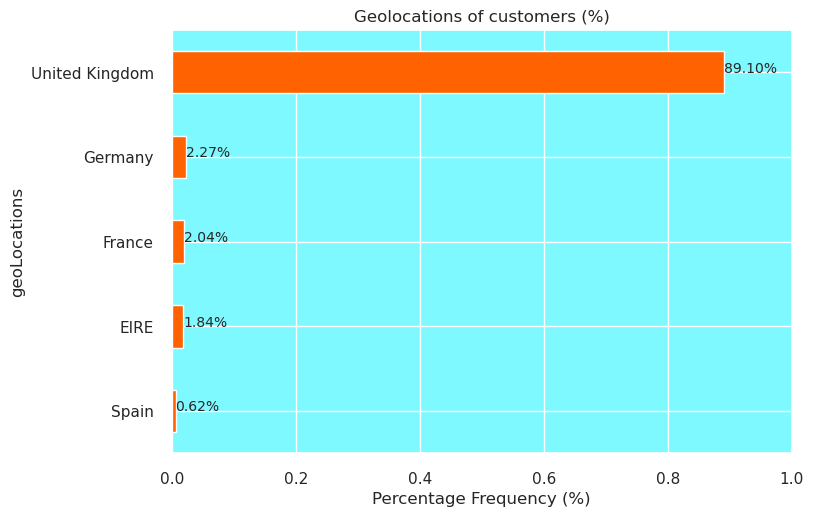

In [38]:
""" Since we don't know the list of countries we have in our dataSet ,
it would be very helpful to know what they are and the exact percentage of customers for each one of them """

# ? note: normalize=True helps give use the percentage of each feild
customer_geo_loc = df['Country'].value_counts(normalize=True).head()

customer_geo_loc.plot(kind='barh', color='#ff6200')

# Plotting just to visualise
for index, value in enumerate(customer_geo_loc):
    plt.text(value, index, f'{(value*100):.2f}%', fontsize=10)

plt.title('Geolocations of customers (%)')
plt.xlabel('Percentage Frequency (%)')
plt.xlim([0, 1])
plt.ylabel('geoLocations')
plt.gca().invert_yaxis()
plt.show()


- Given that a substantial portion (89%) of transactions are originating from the United Kingdom, we might consider creating a binary feature indicating whether the transaction is from the UK or not. This approach can potentially streamline the clustering process without losing critical geographical information

### To perform such approach we will need a method

- First, we'll group the data by `CustomerID` and `Country` and calculate the number of transactions per country for each customer.

- Next, we'll identify the main country for each customer.

- Then, we'll create a binary column indicating whether the customer is from the UK or not.

- Finally, we'll merge this information with the customer_data dataframe to include the new feature in our analysis.

We did notice that a same customer can have transactions from different countries so it should be taken into cosideration too


In [39]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Create a binary column indicating whether the customer is from the UK or not
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Merge this data with our customer_data dataframe
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [40]:
# gives an idea on the geoLocation feature distribution
customer_data['Is_UK'].value_counts()

Is_UK
1    3866
0     416
Name: count, dtype: int64

In this step, I am going to delve deeper into the cancellation patterns of customers to gain insights that can enhance our customer segmentation model. The features I am planning to introduce are:

- Cancellation Frequency: This metric represents the total number of transactions a customer has canceled. Understanding the frequency of cancellations can help us identify customers who are more likely to cancel transactions .

- Cancellation Rate: This represents the proportion of transactions that a customer has canceled out of all their transactions. This metric gives a normalized view of cancellation behavior. A high cancellation rate might be indicative of an unsatisfied customer segment.

This will help us recommend the right products to each customer , as well as build a stronger and a more comprehensive view of customer behavior.

In [41]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Display the first few rows of the customer_data dataframe
customer_data.head()

/tmp/ipykernel_861619/2750596088.py:13: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


### Seasonality & Trends

#### In this step we will consider seasonality and trends in customers , this can offer great opportunities for enhancing customer satisfaction and improve marketing strats even more

- To dod this we will introduce 3 new parameters to our customer_data dataset :
  
  - Monthly_Spending_Mean: this is the average a customer spends monthly , it helps us get an even wider view of the customer's behaviour , spending more indicates that the customer is interested bu more premium products

  - Monthly_Spending_Std: a higher value indicate that the customer's spendings varie a lot durring the month and vis-versa ,  Understanding this variability can help in crafting personalized promotions or discounts during periods they are expected to spend more
  
  (this actually took me a while to understand myself)
  - Spending_Trend: this one might sound strange at first bu what it is for is to reflects the trend in a customer's spending over time, A positive value indicates an increasing trend in spending, possibly pointing to growing loyalty or satisfaction. Conversely, a negative trend might signal decreasing interest or satisfaction, highlighting a need for re-engagement strategies , it's like when you like a place a lot you start buying all sort of stuff from it , this is a way to study such behaviour of "increasing interest"


By incorporating these detailed insights into our customer segmentation model, we can create more precise and actionable customer groups when clustering



In [42]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Calculate Seasonal Buying Patterns: mean and std to see get an idea of the customer's spending variation
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
# this fooled me at first as the data was outputing straight up wrong
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# -> Calculate Trends in Spending

# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for each customer
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

/tmp/ipykernel_861619/1049556668.py:14: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [43]:
# changed customerID type to string since it's not originally meant to be a type number
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()

# seeing if everything is good
customer_data.head(10)


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [44]:
# see all rows we have created and their types
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

here is and overall overview of our newly created dataset

| __Variable__                       | __Description__ |
|     :---                           |       :---      |
| __CustomerID__                     | Identifier uniquely assigned to each customer, used to distinguish individual customers. |
| __Days_Since_Last_Purchase__       | The number of days that have passed since the customer's last purchase. |
| __Total_Transactions__             | The total number of transactions made by the customer. |
| __Total_Products_Purchased__       | The total quantity of products purchased by the customer across all transactions. |
| __Total_Spend__                    | The total amount of money the customer has spent across all transactions. |
| __Average_Transaction_Value__      | The average value of the customer's transactions, calculated as total spend divided by the number of transactions. |
| __Unique_Products_Purchased__      | The number of different products the customer has purchased. |
| __Average_Days_Between_Purchases__ | The average number of days between consecutive purchases made by the customer. |
| __Day_Of_Week__                    | The day of the week when the customer prefers to shop, represented numerically (0 for Monday, 6 for Sunday). |
| __Hour__                           | The hour of the day when the customer prefers to shop, represented in a 24-hour format. |
| __Is_UK__                          | A binary variable indicating whether the customer is based in the UK (1) or not (0). |
| __Cancellation_Frequency__         | The total number of transactions that the customer has cancelled. |
| __Cancellation_Rate__              | The proportion of transactions that the customer has cancelled, calculated as cancellation frequency divided by total transactions. |
| __Monthly_Spending_Mean__          | The average monthly spending of the customer. |
| __Monthly_Spending_Std__           | The standard deviation of the customer's monthly spending, indicating the variability in their spending pattern. |
| __Spending_Trend__                 | A numerical representation of the trend in the customer's spending over time. A positive value indicates an increasing trend, a negative value indicates a decreasing trend, and a value close to zero indicates a stable trend. |

### Now we come to outlier treatement
#### after having created our dataset it's finally time to address outliers

- Since outliers can really screw our clustering it is important to address them , and after we have created our dataset it's safe to try and treat them rn

- Now to the tricky part , as you might have seen in the table above there are A LOT of dimensions , 16 to be exact so we have be careful what algorithm to pick in this case to handle such outliers

- After some researching and looking around (yes i did not want just to copy blindly what people did) we will be using the Isolation **Forest algorithm** for this task , as it relies on decision trees to perform it computation -> meaning it is very good when it comes to multiple dimension

-> i don't want to get too deep into details here XD , but you can check [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html)

In [45]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0) # inetrestingly , 0.05 or 5% seems to be the outliers percentage hmmmmmm

# Fitting the model on our dataset
# (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


After applying the Isolation Forest algorithm, we have identified the outliers and marked them in a new column named `Is_Outlier`

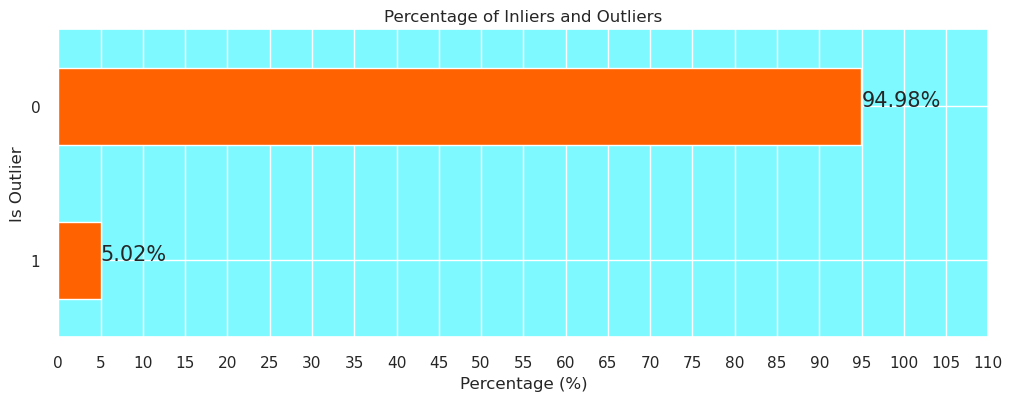

In [46]:
# let's visualise the percentage of outliers left in our dataset (one we created)

# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()


from the plot above we have about 5% of customers that have been flagged as outliers in our dataset , which is a resonable percentage , not too high and not too low

Concidering our dataset here , it is best practice to handle these outliers to prevent any potential noise , or inconsistency and probably analyse those outliers more , to do that we will

- Remove the outliers from the main dataset to prevent them from influencing the clustering process.
- Drop the `Outlier_Scores` and `Is_Outlier` columns that we created since they don't serve any purpose rn.

In [47]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]
# ^ keeping this for potential further analysis ^

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [48]:
# now we have a completely cleaned data
customer_data_cleaned.shape[0]

4067

### Correlation analysis
#### Before moving to the clustring we have to check one very important thing , correlation:

- The presence of multicollinearity, where features are highly correlated, can potentially affect the clustering process by not allowing the model to learn the actual underlying patterns in the data, as the features do not provide unique information , this could cause problems while clustering so let's analyse

- seeing how the data has many dimensions we'll try visualise correlation using a heatmap

- in case of multicollinearity we can ustilize dimensionality reduction techniques like PCA. (i did not hear that term in a long time ...oof)

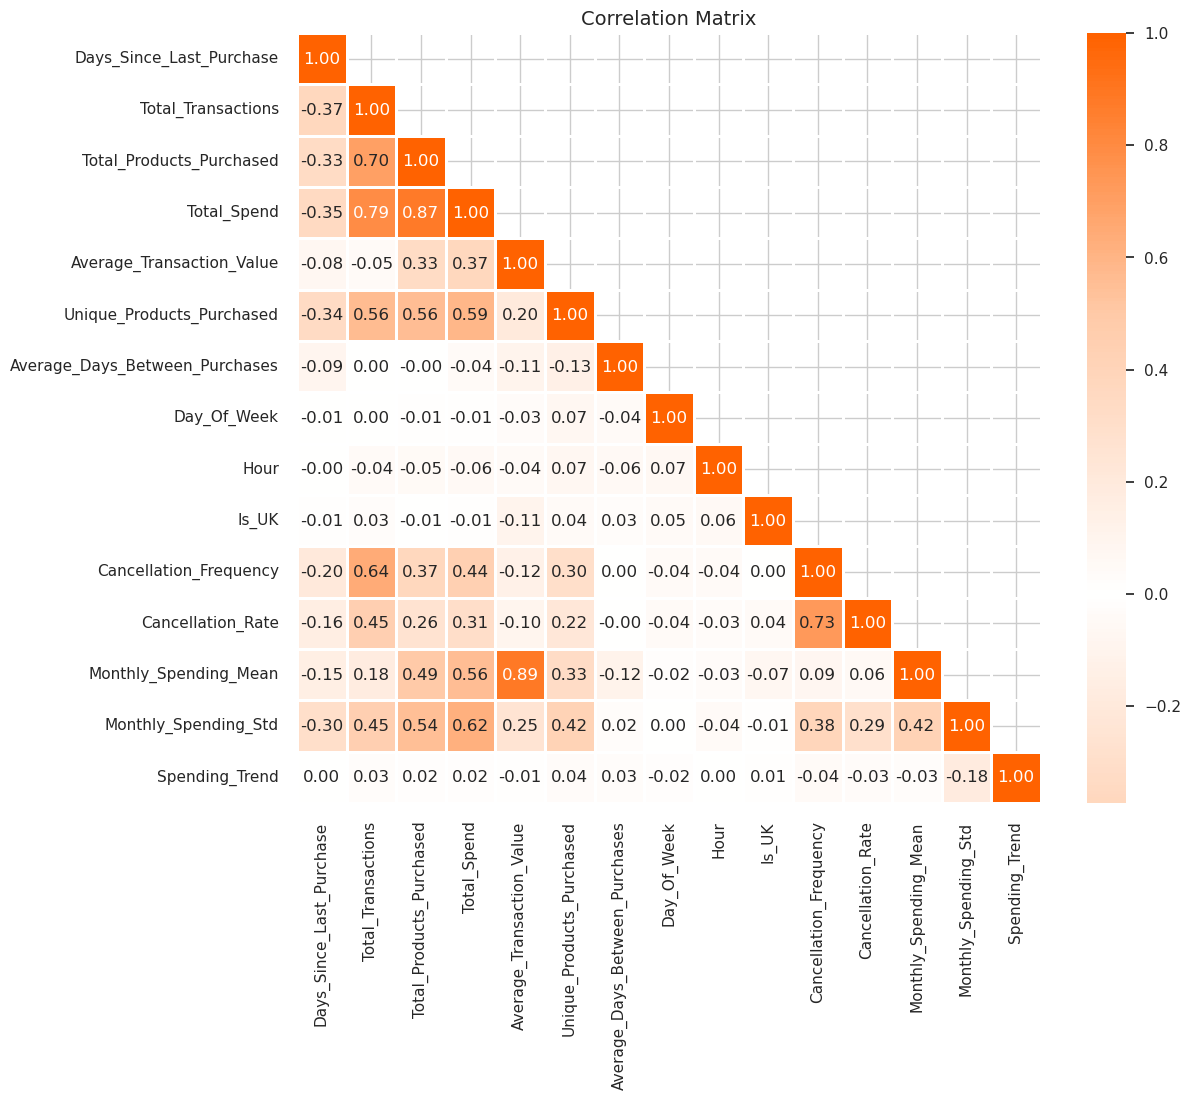

In [49]:
# Reset background style
sns.set_style('whitegrid')

# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Define a custom colormap
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# ? Originally the heatmap is mirrored which we do not want for the sake of clarity

# to avoid that we create a mask to only show the lower triangle of the matrix (since it's mirrored around its
# top-left to bottom-right diagonal)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [50]:
import matplotlib as mpl

print(sns.__version__)
print(mpl.__version__)

# make sure to update to seaborn v0.13.0 or above

0.13.2
3.8.4


### Back to correlation

Looking at the heatmap, we can see that there are some pairs of variables that have high correlations, for instance:

- `Monthly_Spending_Mean` and `Average_Transaction_Value`

- `Total_Spend` and `Total_Products_Purchased`

- `Total_Transactions` and `Total_Spend`

- `Cancellation_Rate` and `Cancellation_Frequency`

- `Total_Transactions` and `Total_Products_Purchased`

These high correlations indicate that these variables move closely together, implying a degree of multicollinearity.

### Feature scaling

Before we move forward with the clustering and dimensionality reduction, it's imperative to scale our features. This step holds significant importance, especially in the context of distance-based algorithms like K-means , since :

- K-means relies A LOT on the concept of **distance** between data points to form its cluster.
- For PCA , it aims to find the directions where the data varies the most. When features are not scaled, those with larger values might dominate these components,thus resulting in a lack of accurecy

#### To do thos we will need standarize (standariser) our data meaning -> we will need transform the features to have a mean of 0 and a std of 1

- However after further speculation , we found that not all the features need standerizing , which are these :

    - CustomerID: this is just a representer of the id of customers and does not containt any info
    - is_UK : since this is either 0 or 1 , scaling will not affect it all
    - Day_Of_Week: this one is interesting since its values are limited (only int values between 1 and 7 both included) , so scaling it would not be necessary (this is actually what i found upon reading a lot of articles)

Ok , let's begin the scaling shall we :

In [51]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week'] # Like we mentionned above

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset , since we want to preserve the cleaned data for further analysis
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


### Dimensionality Reduction

#### You may ask , when are we gonna get to K-means ?
To answer your question , here is why :
- 1) **We detected multicoliniarity** : as we saw previously in the heatmap there are a lot of variables that are correlated between each other , this step will help us remove redundant information and alleviate the multicollinearity issue.
- 2) **Better Clustering with K-means** : like we mentionned earlier K-means is a distance-based clustering algorithm , and having a large number of features can sometimes dilute the meaningful underlying patterns in the data , dimension reduction (like the name says) will help us reduce the number of these features while keeping the data meaningfull
- 3) **Noise reduction** : By focusing only on the most important features, we can potentially remove noise in the data.
- 4) **Enhanced Visualization** :  In the context of customer segmentation, being able to visualize customer groups in two or three dimensions can provide intuitive insights. Dimensionality reduction techniques can facilitate this by reducing the data to a few principal components which can be plotted easily.
- 5) **Optimisation** : the concept is simple -> the lesser we have the faster we can finish

#### Like we said before we are going to use PCA fo our reduction algorithm

- Note : It's essential to note that we are keeping our options open. After applying PCA, if we find that the first few components do not capture a significant amount of variance, indicating a loss of vital information, we might consider exploring other non-linear methods

- We will apply PCA on **all** the available components and plot the cumulative variance explained by them. This process will allow us to visualize how much variance each additional principal component can explain (to basically know what components to retrieve for the analysis)

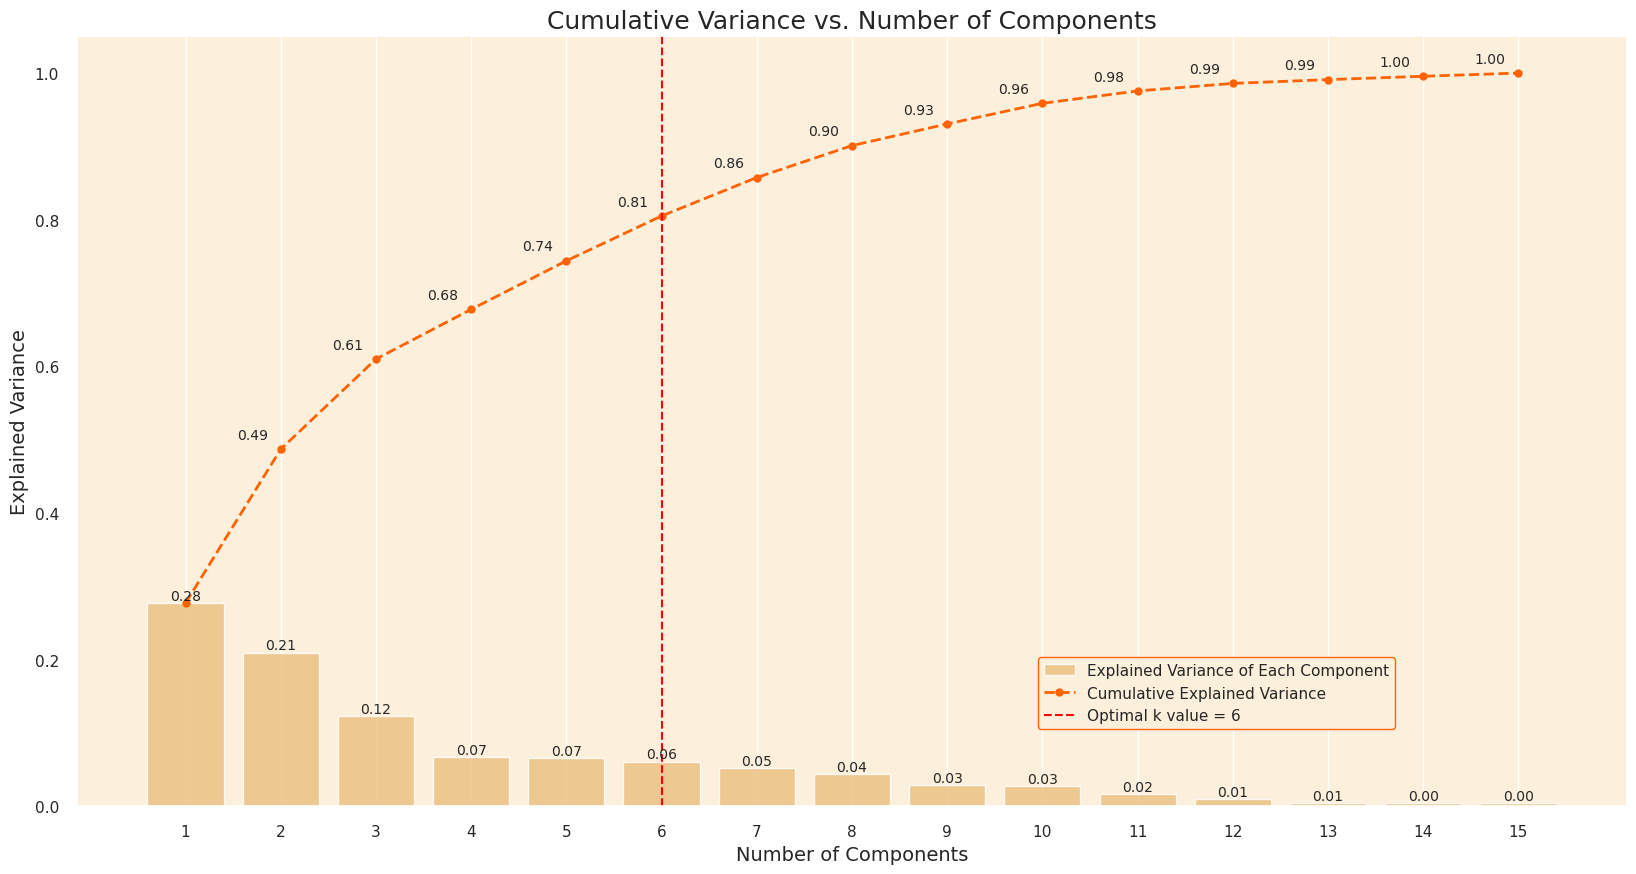

In [52]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('CustomerID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set_theme(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()

# also used standard ploting here instead of that big circle i used use

#### The plot and the cumulative explained variance values indicate how much of the total variance in the dataset is captured by each principal component , as we can see from the graph 6 is the optimal k value and we can observe from the graph that:

- The first component explains approximately 28% of the variance.

- The first two components together explain about 49% of the variance.

- The first three components explain approximately 61% of the variance, and so on.

To choose the optimal K-value here we will have to look where adding another component doesn't significantly increase the cumulative explained variance, often referred to as the **"elbow point"** in the curve.

As we can see from the plot the increase in cumulative variance starts to slow down after the 6th component (which captures about 81% of the total variance).

In conclusion : We are gonna use the first 6 components to retain a sufficient amount of information to identify distinct customer groups effectively and not loose too much meaning in the process






In [53]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index


In [54]:
# Displaying the resulting dataframe based on the Principal comonents
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,-0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,-0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,0.183682,-1.484838,0.062672


##### Now, let's extract the coefficients corresponding to each principal component to better understand the transformation performed by PCA:

In [55]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ff6200' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)



,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217859,-0.013986,0.067660,0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,-0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,-0.134806,0.057476,-0.013373
Total_Spend,0.431260,0.010159,0.065165,-0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,0.114307,0.021847,-0.101738
Unique_Products_Purchased,0.324992,0.063346,0.014010,-0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,-0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,-0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,-0.013419,-0.005353,0.014384


***K-Means Clustering***

**Determining the Optimal Number of Clusters -
methode 1: Elbow Method**


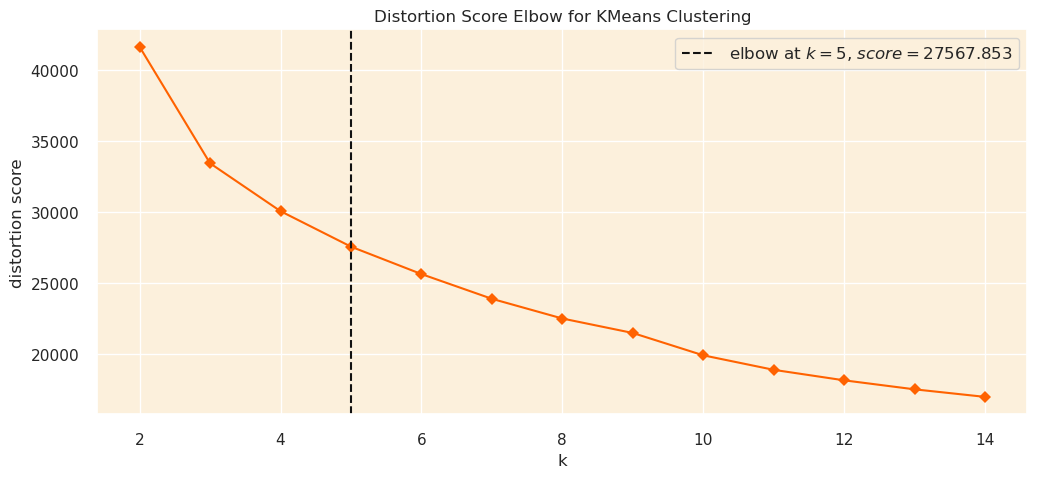

In [56]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

**Determining the Optimal Number of Clusters -
methode 2: Silhouette Method**


In [57]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Assign the plots to the second, third, and fourth rows
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Add the Silhouette score text to the plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()

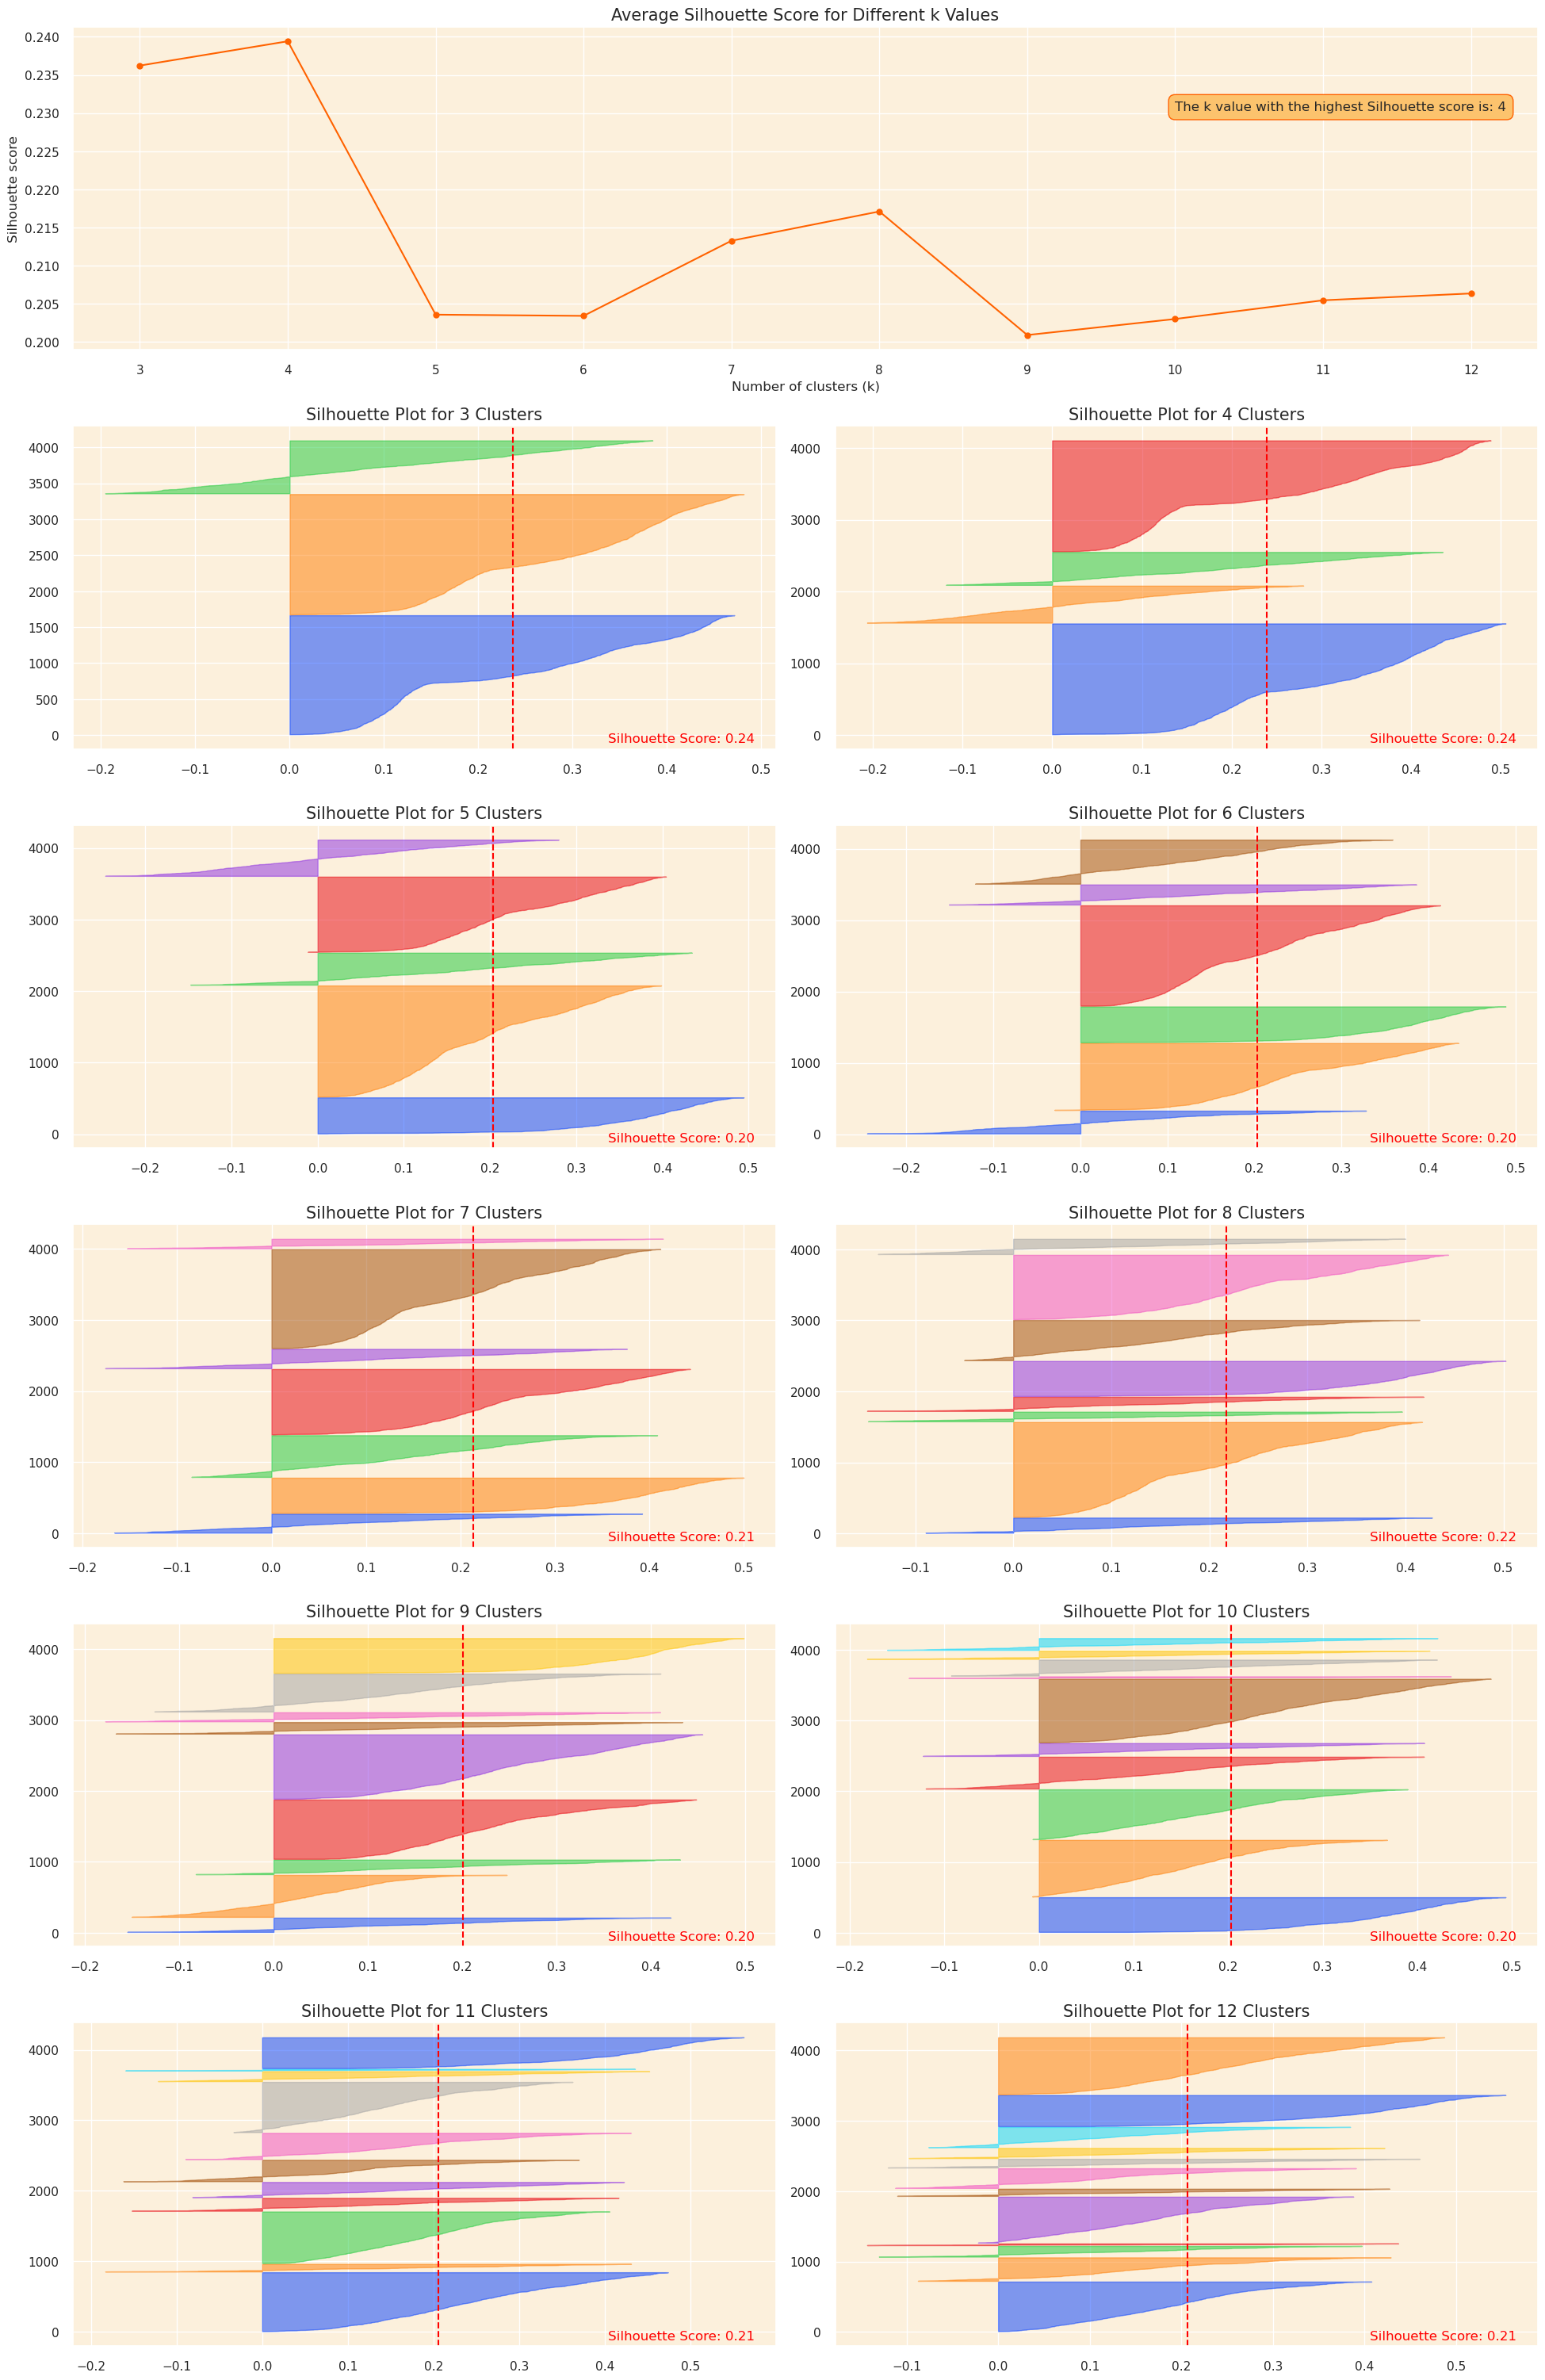

In [58]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

**Clustering Model - K-means**

In [59]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [60]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,2
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,2
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,2


**Clustering Evaluation**

***3D Visualization of Top Principal Components***

In [61]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']

In [62]:
import pandas as pd
import plotly.graph_objs as go

# Assuming 'customer_data_pca' is your DataFrame and 'colors' is a list of color codes

# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(
    x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
    mode='markers',
    marker=dict(color=colors[0], size=5, opacity=0.4),
    name='Cluster 0'
))
fig.add_trace(go.Scatter3d(
    x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
    mode='markers',
    marker=dict(color=colors[1], size=5, opacity=0.4),
    name='Cluster 1'
))
fig.add_trace(go.Scatter3d(
    x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
    mode='markers',
    marker=dict(color=colors[2], size=5, opacity=0.4),
    name='Cluster 2'
))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=600,
    height=600
)

# Show the plot
fig.show()

***Cluster Distribution Visualization***

/tmp/ipykernel_861619/1531732811.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




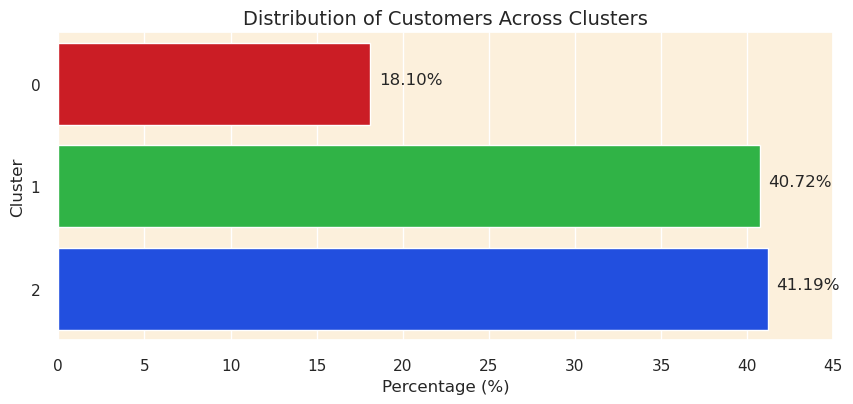

In [63]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

***Evaluation Metrics***

In [64]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23622848017098888 |
| Calinski Harabasz Score | 1257.1747766540623  |
|  Davies Bouldin Score   | 1.3682695376074658  |
+-------------------------+---------------------+


**Cluster Analysis and Profiling**

***Radar Chart Approach***

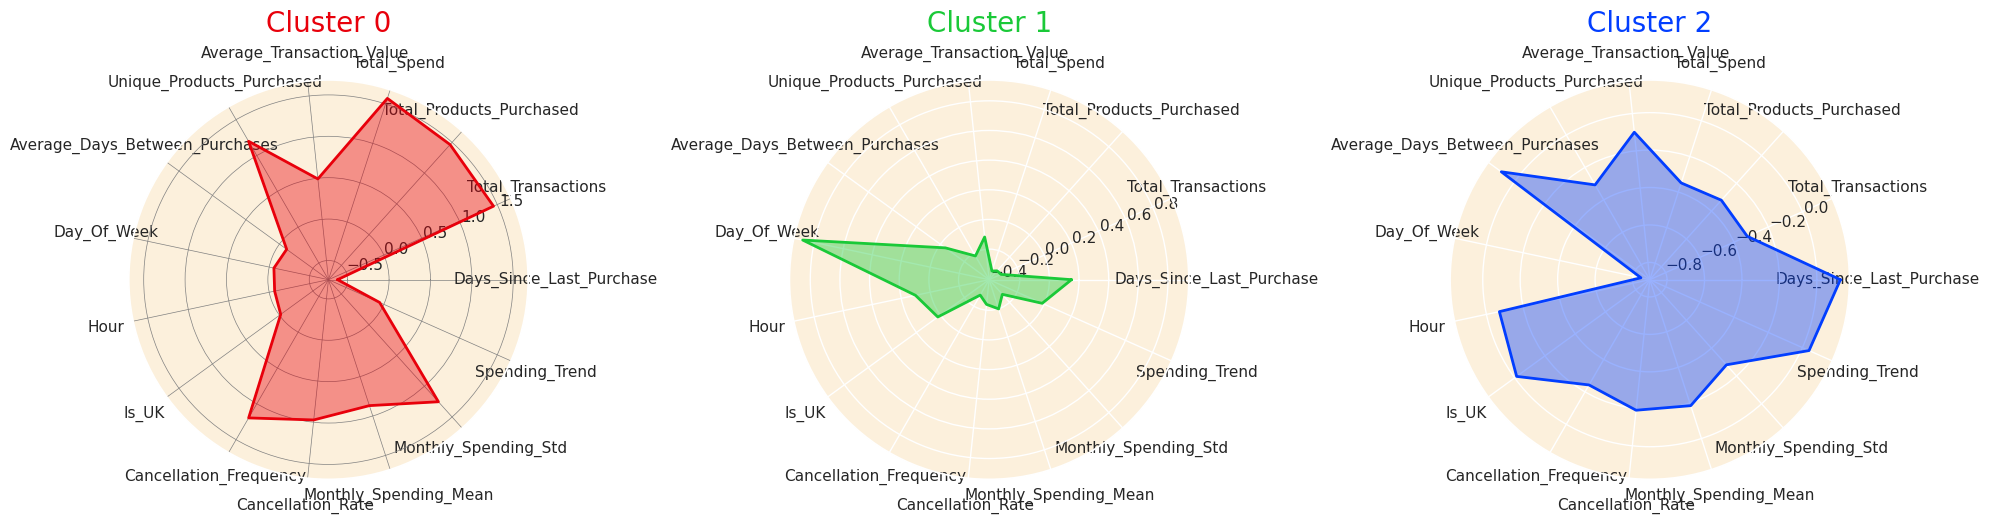

In [65]:
#Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

***Histogram Chart Approach***

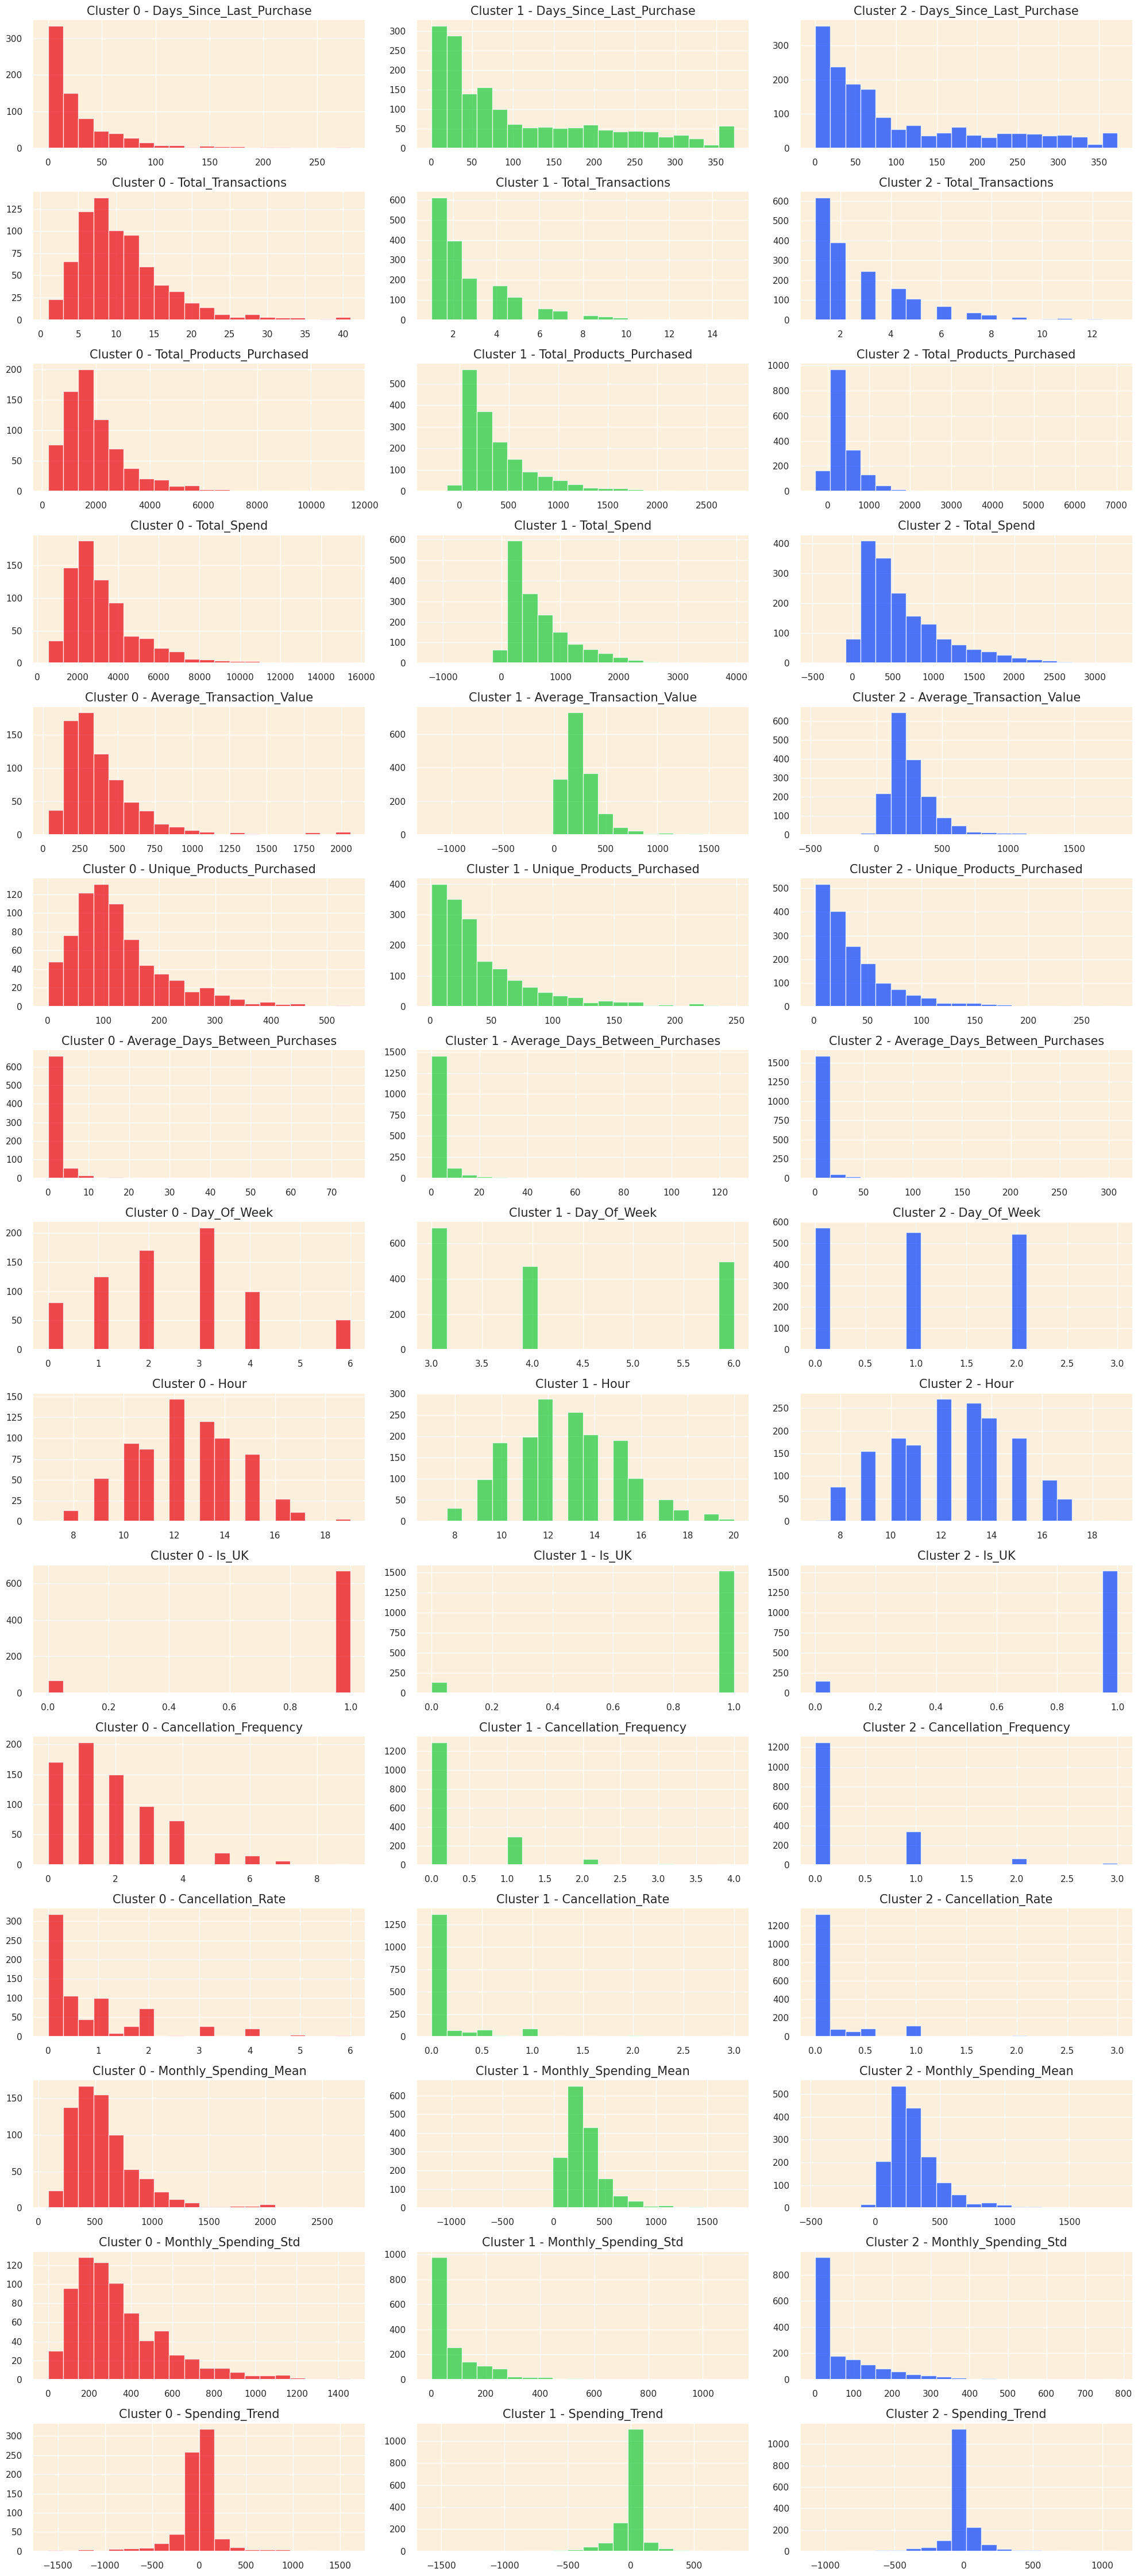

In [66]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

**Recommendation System**

In [67]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())
# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [68]:
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
13243.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
13232.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
14997.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14948.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
12596.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
16686.0,22616,PACK OF 12 LONDON TISSUES,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
17101.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14954.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
18123.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
